# **Deep Medic**

##**1.0 Setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
!pip3 install SimpleITK
!pip3 install imageio
!pip3 install scikit-image
!pip3 install seaborn
!pip install torchio
import torchio as tio

import random 
import SimpleITK as sitk
import time
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import torchvision
import scipy.misc
import imageio
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.transform import resize
from torchvision import transforms, utils
import time
import seaborn as sns
!pip install torch-summary
from torchsummary import summary
import torch.optim as optim
from SimpleITK.SimpleITK import LabelMapMaskImageFilter
!pip install nilearn 
import nibabel as nib
from nilearn import plotting
import json


save_path = 'results'

if not os.path.exists(save_path):
    os.makedirs(save_path)

     |████████████████████████████████| 48.4 MB 1.2 MB/s 
     |████████████████████████████████| 164 kB 4.2 MB/s 
     |████████████████████████████████| 10.1 MB 4.2 MB/s 


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device) 

cuda


## **2.0 Taking a first look at the data**

(512, 512, 80) (512, 512, 80)
torch.Size([80, 512, 512])


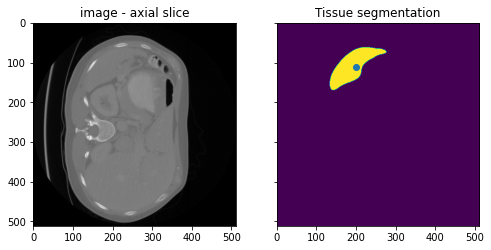

In [4]:
directory = '/content/drive/MyDrive/AML/Task09_Spleen'  # we define the directory of the data

image_file=nib.load(os.path.join(directory,'imagesTr/spleen_62.nii.gz')) # see here use of os.path.join to create the final path
segmentation_file=nib.load(os.path.join(directory,'labelsTr/spleen_62.nii.gz'))

img=image_file.get_fdata().astype(float)
seg=segmentation_file.get_fdata().astype(np.int32)
print(img.shape,seg.shape)

#CONVERT TO TENSORS AND RESHAPE
img_tensor = torch.from_numpy(img).to(torch.float).permute(2,0,1)
seg_tensor=torch.from_numpy(seg).to(torch.int).permute(2,0,1)
print(img_tensor.shape)

#PLOTTING
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(8, 4))
ax[0].imshow(img_tensor[64], cmap=plt.cm.gray)
ax[0].set_title('image - axial slice')
ax[1].imshow(seg_tensor[64])
ax[1].set_title('Tissue segmentation')
ax[1].scatter(200,110)
plt.show()

## **3.0 Creating our dataset and dataloader**

Now, since the images are not indexed 0,1,2,3 (but rather 2,3,6,8 etc) we need a way of returning the paths of the data from an index for the dataloaders to work. Use our json file!

In [5]:
meta_path=os.path.join(directory,'dataset.json')
with open(meta_path, 'r') as f:
  data = json.load(f)
meta = data['training']

### **Sampling weighted 3D patches**

We want one low res (19x19x19) input segment and one normal res (25x25x25) input segment. The low resolution segment is taken from a downsampled version of the original image which has been scaled down by a factor of 3. 

Note: In our case, some of the images will be too small for us to acheive a 19x19x19 image. However, the size of our subpatches can be changed without problem (and is even suggested in the original paper) so we reduce them to 15x15x15 and also decrease the scale factor to 2.

Coordinates of patch centre: [309. 105.  47.]


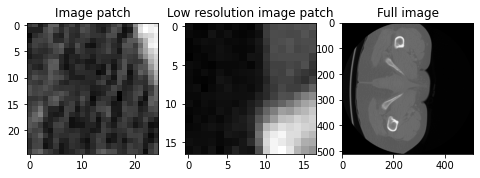

AA (17, 17, 17)
(25, 25, 25)


In [6]:
from skimage.measure import block_reduce

def sample_weighted_3d_patch(image, weight_map, patch_size=25, sub_patch_size =17, net_size = 9, acceptance_threshold=0, seed=None, scale_factor = 2):
    np.random.seed(seed)
    scaledimage = block_reduce(image, block_size=(scale_factor,scale_factor,scale_factor), func = np.mean) 
    scaledlabels = block_reduce(weight_map, block_size=(scale_factor,scale_factor,scale_factor), func=np.mean).astype(int)

    patch_rejection = True
    while patch_rejection:
        shape = scaledimage.shape
        max_coords = np.array(shape) - sub_patch_size
        #print('A',max_coords)
        startcoords = np.zeros(len(shape), dtype=np.int32)

        for dim in range(len(shape)):
            if max_coords[dim] <= 0: 
              #pad the image
              padding = int(np.ceil(-1*max_coords[dim]/2))
              #print('MAXCOORDS',max_coords,'PADDING',padding)
              padlist = [(0,0),(0,0),(0,0)]
              padlist[dim] =(padding,padding)
              scaledimage = np.pad(scaledimage, padlist, mode='edge')
              scaledlabels = np.pad(scaledlabels, padlist, mode= 'edge')
              #print(scaledimage.shape)
              max_coords[dim] = 0
            else:
              #Randomly pick a starting point for the patch, for each dimension
              startcoords[dim]  = np.random.randint(0, max_coords[dim])

            endcoords = startcoords + sub_patch_size
            weight_patch = scaledlabels[startcoords[0] : endcoords[0],
                                        startcoords[1] : endcoords[1],
                                        startcoords[2] : endcoords[2]]  

            normalised_weight_sum = np.sum(weight_patch[:]) / weight_patch.size
            patch_rejection = normalised_weight_sum < acceptance_threshold
    #print('Scaledimshape', scaledimage.shape)
    sub_patch = scaledimage[startcoords[0] : endcoords[0],
                            startcoords[1] : endcoords[1],
                            startcoords[2] : endcoords[2]]
    label_sub_patch = scaledlabels[startcoords[0] : endcoords[0],
                                   startcoords[1] : endcoords[1],
                                   startcoords[2] : endcoords[2]]
    #find and upscale the coordinates of the centre of the patch
    #print('END',endcoords)
    centercoords = (startcoords+endcoords)/2*scale_factor
    #print(centercoords)
    starting_patch_coords = (centercoords - np.ceil(patch_size/2)).astype(int)
    #print(starting_patch_coords)
    end_patch_coords = (centercoords + np.floor(patch_size/2)).astype(int)
    #print(end_patch_coords)
    image_patch = image[starting_patch_coords[0]:end_patch_coords[0],
                        starting_patch_coords[1]:end_patch_coords[1],
                        starting_patch_coords[2]:end_patch_coords[2]]

    label_patch = weight_map[starting_patch_coords[0]:end_patch_coords[0],
                             starting_patch_coords[1]:end_patch_coords[1],
                             starting_patch_coords[2]:end_patch_coords[2]]
  
    starting_patch_coords = (centercoords - np.ceil(net_size/2)).astype(int)
    end_patch_coords = (centercoords + np.floor(net_size/2)).astype(int)
    network_label_patch = weight_map[starting_patch_coords[0]:end_patch_coords[0],
                                 starting_patch_coords[1]:end_patch_coords[1],
                                 starting_patch_coords[2]:end_patch_coords[2]]
    return image_patch, sub_patch, label_patch, label_sub_patch, network_label_patch, centercoords

weight_map = seg
image_patch, sub_patch, label_patch, label_sub_patch, net_label_patch, centercoords= sample_weighted_3d_patch(img, weight_map)

print(f'Coordinates of patch centre: {centercoords}')


fig, ax = plt.subplots(ncols=3, sharex=False, sharey=False,
                       figsize=(8, 4))
ax[0].imshow(image_patch[:,:,0], plt.cm.gray)
ax[0].set_title('Image patch')
ax[1].imshow(sub_patch[:,:,0], plt.cm.gray)
ax[1].set_title('Low resolution image patch')
ax[2].imshow(img[:,:,0],plt.cm.gray)
ax[2].set_title('Full image')
plt.show()
print('AA',label_sub_patch.shape)
print(image_patch.shape)
#print(segmentation_patch.shape)

In [ ]:
"""
# CHECKING FUNCTION TO LOWER RESOLUTION 
img = block_reduce(img, block_size=(2,2,2), func =np.mean) 
plt.imshow(img[:,:,0], plt.cm.gray)
plt.show()
print(img.shape)
"""

### **Create a custom dataset**

In [7]:
#WE NEED THE SHAPE TO BE BATCH X CHANNELS X DEPTH X HEIGHT X WIDTH, Channels = 1 so we get BATCH X  DEPTH X HEIGHT X WIDTH
class SpleenSegmentationDataset(torch.utils.data.Dataset): 
    
    def __init__(self, meta, directory, transform=None): 

        self.directory = directory   
        self.meta = meta
        self.transform= transform
        
    def __len__(self):
        return len(meta)
    
    def __getitem__(self, idx, patch_size=25,sub_patch_size= 17, acceptance_threshold=0.1, seed=42):
        # we dont want the acceptance threshold to be too high 
        meta_sample=self.meta[idx] # this will return the idx-th element from the dataframe
        image_name = os.path.join(directory, meta_sample['image'])  
        label_name = os.path.join(directory, meta_sample['label']) 
         
        image=nib.load(image_name).get_fdata().astype(float)
        labels=nib.load(label_name).get_fdata().astype(np.int32)
        weight_map = labels
        image_patch, sub_patch, label_patch, label_sub_patch, net_label_patch, centercoords= sample_weighted_3d_patch(image, weight_map,patch_size,sub_patch_size, 9, acceptance_threshold)

        #converting to tensors 
        img_tensor = torch.from_numpy(image_patch).to(torch.float)
        sub_patch_tensor = torch.from_numpy(sub_patch).to(torch.float)
        seg_tensor=torch.from_numpy(label_patch).to(torch.int)
        small_seg_tensor = torch.from_numpy(label_sub_patch).to(torch.int)
        segmentation_tensor = torch.from_numpy(net_label_patch).to(torch.int)

        #print(img_tensor.shape, sub_patch_tensor.shape, seg_tensor.shape, small_seg_tensor.shape)
        
        
        # reshape to expected dimensions using permute and unsqueeze DO WE NEED TO PERMUTE?? 
        img_tensor=img_tensor.permute(2,0,1).unsqueeze(0)
        sub_patch_tensor = sub_patch_tensor.permute(2,0,1).unsqueeze(0)
        seg_tensor=seg_tensor.permute(2,0,1).unsqueeze(0)
        small_seg_tensor = small_seg_tensor.permute(2,0,1).unsqueeze(0)
        segmentation_tensor = segmentation_tensor.permute(2,0,1).unsqueeze(0)

        #print(img_tensor.shape, seg_tensor.shape, sub_patch_tensor.shape, small_seg_tensor.shape, segmentation_tensor.shape)
        
      
        if self.transform:
            img_tensor = self.transform(img_tensor)
            sub_patch_tensor = self.transform(sub_patch_tensor)

        # convert to  tuple and return
        sample = img_tensor, seg_tensor, sub_patch_tensor, small_seg_tensor, segmentation_tensor   

        return sample

**Check that our dataset is working**

Dataset length is: 41
torch.Size([1, 25, 25, 25]) torch.Size([1, 25, 25, 25]) torch.Size([1, 17, 17, 17]) torch.Size([1, 17, 17, 17])


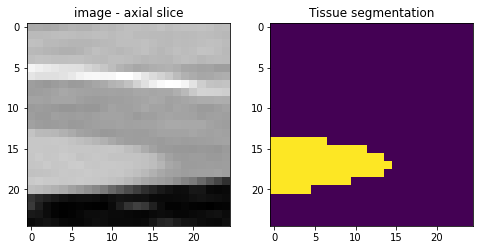

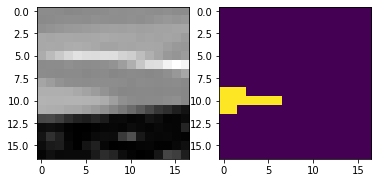

In [8]:
ds = SpleenSegmentationDataset(meta, directory)
print(f'Dataset length is: {ds.__len__()}')
image, segmentation, sub_patch, sub_patch_segmentation, net_segmentation_patch = ds.__getitem__(3, acceptance_threshold = 0.1, seed = None, patch_size = 25)
print(image.shape, segmentation.shape, sub_patch.shape, sub_patch_segmentation.shape)

#PLOTTING
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=False,
                       figsize=(8, 4))
ax[0].imshow(image[0,:,:,0], cmap=plt.cm.gray)
ax[0].set_title('image - axial slice')
ax[1].imshow(segmentation[0,:,:,0])
ax[1].set_title('Tissue segmentation')

fig1, ax1 = plt.subplots(ncols = 2)
ax1[0].imshow(sub_patch[0,:,:,0], cmap = plt.cm.gray)
ax1[1].imshow(sub_patch_segmentation[0,:,:,0])
plt.show()

### **Creating our dataloaders**

In [9]:
train_size= 35
test_size= 6

# TRAIN TEST SPLIT
train_set, test_set = torch.utils.data.random_split(ds,[train_size, test_size])

#TRAIN AND TEST LOADERs
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=6, shuffle = True)
im_batch, lab_batch, small_im_batch, small_seg_batch, segmentation = next(iter(train_loader))


# get a batch to check shape
print('batch shape', im_batch.shape) 
print('batch shape', small_im_batch.shape)
print(segmentation.shape)

batch shape torch.Size([10, 1, 25, 25, 25])
batch shape torch.Size([10, 1, 17, 17, 17])
torch.Size([10, 1, 9, 9, 9])


##**4.0 Creating a Deep Medic**

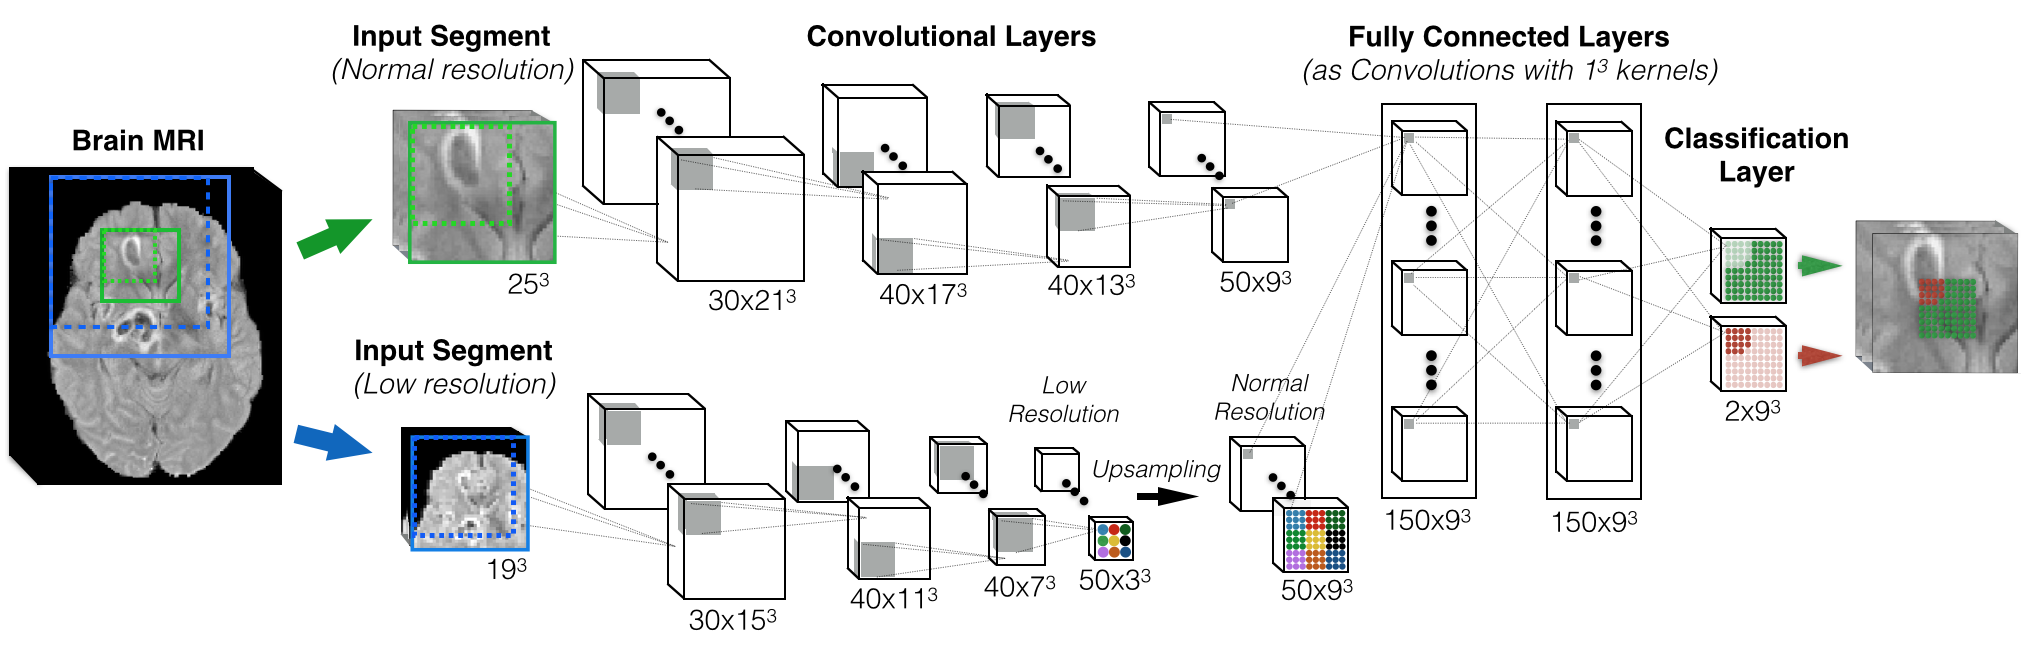

### version 1

In [ ]:
import torch.nn as nn
import math
import torch

def conv3x3(in_planes, out_planes, ksize=3):
    return nn.Sequential(
            nn.Conv3d(in_planes, out_planes, ksize),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(inplace=True))

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.branch1 = nn.Sequential(
                conv3x3(4, 30),
                conv3x3(30, 30),
                conv3x3(30, 40),
                conv3x3(40, 40),
                conv3x3(40, 40),
                conv3x3(40, 40),
                conv3x3(40, 50),
                conv3x3(50, 50))

        self.branch2 = nn.Sequential(
                conv3x3(4, 30),
                conv3x3(30, 30),
                conv3x3(30, 40),
                conv3x3(40, 40),
                conv3x3(40, 40),
                conv3x3(40, 40),
                conv3x3(40, 50),
                conv3x3(50, 50))

        self.fc = nn.Sequential(
                conv3x3(100, 150, 1),
                conv3x3(150, 150, 1),
                nn.Conv3d(150, 5, 1))

    def forward(self, inputs):
        x1, x2 = inputs
        x1 = self.branch1(x1)
        x2 = self.branch2(x2)
        x2 = x2.repeat(1, 1, 3, 3, 3)
        x = torch.cat([x1, x2], 1)
        x = self.fc(x)
        return x

### **Network**

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import math
import torch

# adapted from https://github.com/Kamnitsask/deepmedic (official paper) and https://github.com/pykao/BraTS2018-tumor-segmentation/blob/master/models/deepmedic.py 

class ResBlock(nn.Module):
    def __init__(self, inplanes, planes):
        super(ResBlock, self).__init__()
        self.inplanes = inplanes
        self.conv1 = nn.Conv3d(inplanes, planes, 3, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(planes, planes, 3, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        y = self.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        x = x[:, :, 2:-2, 2:-2, 2:-2]
        y[:, :self.inplanes] += x
        y = self.relu(y)
        return y

def conv3x3(inplanes, planes, ksize=3):
    return nn.Sequential(
            nn.Conv3d(inplanes, planes, ksize, bias=False),
            nn.BatchNorm3d(planes),
            nn.ReLU(inplace=True))

def repeat(x, n=3):
    # nc333
   
    b, c, h, w, t = x.shape
    x = x.unsqueeze(5).unsqueeze(4).unsqueeze(3)
    x = x.repeat(1, 1, 1, n, 1, n, 1, n)
    return x.view(b, c, n*h, n*w, n*t)


class DeepMedic(nn.Module):
    def __init__(self, c=1, n1=30, n2=40, n3=50, m=150, up=True):
        super(DeepMedic, self).__init__()
        #n1, n2, n3 = 30, 40, 50

        n = 2*n3
        self.branch1 = nn.Sequential(
                conv3x3(c, n1),
                conv3x3(n1, n1),
                ResBlock(n1, n2),
                ResBlock(n2, n2),
                ResBlock(n2, n3))

        self.branch2 = nn.Sequential(
                conv3x3(c, n1,),
                conv3x3(n1, n1),
                conv3x3(n1, n2),
                conv3x3(n2, n2),
                conv3x3(n2, n2),
                conv3x3(n2, n2),
                conv3x3(n2, n3),
                conv3x3(n3, n3))

        self.up3 = nn.Upsample(scale_factor=3,
                mode='trilinear', align_corners=False) if up else repeat

        self.fc = nn.Sequential(
                conv3x3(100, 150, 1),
                conv3x3(150, 150, 1),
                nn.Conv3d(150, 1, 1))
      

    def forward(self, inputs, small_inputs):
        x1, x2 = inputs, small_inputs
        x1 = self.branch1(x1)
        x2 = self.branch2(x2)
        x2 = self.up3(x2)
        x2 = self.up3(x2) #we add antóther upsampling since weve reduced the image size of the subpatches from 19 to 17
        x = torch.cat([x1, x2], 1)
        x = self.fc(x)
        return x



### **Loss Functions**

"[Train] using the RMSProp optimizer
(Tieleman and Hinton (2012)) and Nesterov momentum (Sutskever et al.
(2013)) with value m = 0.6. L1 = 10−6 and L2 = 10−4
regularisation is applied. We train the networks with dense-training on batches of 10 segments, each of size 25^3"


In [11]:
from torch.nn.modules.module import T
#we want our results to be reproducible so: 
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# CREATE LOSS OBJECT AND OPTIMISER

#weights = torch.tensor()
#the energy function is computed by a pixel-wise soft-max over the final feature map combined with the cross entropy loss function.

def dice_coeff(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    smooth = 1.
    epsilon = 10e-8

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    #print(iflat.shape)
    tflat = target.contiguous().view(-1)
    #print(tflat.shape)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)

    dice = (2. * intersection + smooth) / (A_sum + B_sum + smooth)
    dice = dice.mean(dim=0)
    dice = torch.clamp(dice, 0, 1.0-epsilon)

    return  dice

#WE USE BCE INSTEAD OF CROSS ENTROPY BC THERE ARE ONLY TWO CLASSES (SPLEEN OR NO SPLEEN)
pos_weight = torch.tensor((1.1))
pos_weight = pos_weight.to(device)
loss_fun = torch.nn.BCELoss(weight = pos_weight)

### **Training**

use batch size ten as in the og paper 
lr 1e-4 converges steadily but slightly slowly
lr 1e-3 faster but less stabel 
fix this by having decaying lr? 
momentum of 0.5 - more smooth 

In [ ]:
epochs = 20
train_loss = []
val_loss=[]
dice_scores= []
path1 ='/content/drive/MyDrive/AML/FinalProjectSavedModels/train/train_model.pt'
path2 = '/content/drive/MyDrive/AML/FinalProjectSavedModels/eval/test_model.pt'
SAVE_EVERY = 2

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#CREATE INSTANCE OF NETWORK & PASS TO NETWORK
deepmedic = DeepMedic()
deepmedic = deepmedic.to(device)
#deepmedic.load_state_dict(torch.load(path1))

optim = torch.optim.RMSprop(deepmedic.parameters(), lr=1e-4, momentum = 0.6, weight_decay =1e-4)
#optim = torch.optim.Adam(deepmedic.parameters(), lr=1e-4, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=6, gamma=0.1)


for epoch in range(epochs): 
    # enumerate can be used to output iteration index i, as well as the data 
    deepmedic.train()
    for i, (patch, seg, sub_patch, sub_patch_seg, net_seg) in enumerate(train_loader, 0):
        #print(patch.shape, seg.shape, sub_patch.shape, sub_patch_seg.shape)
        patch,sub_patch, net_seg = patch.to(device), sub_patch.to(device), net_seg.type(torch.FloatTensor).to(device)
        optim.zero_grad()
        output=deepmedic(patch, sub_patch)
        
        loss=loss_fun(torch.sigmoid(output),net_seg) #NOTE WE USE SIGMOID INSTEAD OF SOFTMAX SINCE ITS A BINARY SEGMENTATION PROBLEM
        loss.backward()
        optim.step()
        
        # print statistics of loss tensor
        ce_loss = loss.item()
        train_loss.append(ce_loss)
        if i % 5 == 0:
            print('[%d, %5d] train loss: %.3f' %
                  (epoch + 1, i + 1, ce_loss))
    if epoch% SAVE_EVERY ==0:
        torch.save(deepmedic.state_dict(), path1)
    scheduler.step()

    deepmedic.eval()
    for i, (patch, seg, sub_patch, sub_patch_seg, net_seg) in enumerate(test_loader, 0):
        patch,sub_patch, net_seg = patch.to(device), sub_patch.to(device), net_seg.type(torch.FloatTensor).to(device)
        pred=deepmedic(patch, sub_patch)
        loss=loss_fun(torch.sigmoid(pred),net_seg)
        ce_loss = loss.item()
        val_loss.append(ce_loss)
        dicescore =dice_coeff(pred, net_seg)
        dicescore = dicescore.item()       
        dice_scores.append(dicescore)
        if i% 5 == 0:
          print('[%d, %5d] val loss: %.3f' %
          (epoch + 1, i + 1, ce_loss))
    if epoch% SAVE_EVERY ==0:
        torch.save(deepmedic.state_dict(), path2)

#SAVING OUR LOSS LISTS
import pickle
my_file = '/content/drive/MyDrive/AML/FinalProjectSavedModels/train/losses'
with open(my_file, 'wb') as f:
    pickle.dump(train_loss, f)

my_file2 = '/content/drive/MyDrive/AML/FinalProjectSavedModels/eval/losses'
with open(my_file2, 'wb') as f:
    pickle.dump(val_loss, f)

my_file3 = '/content/drive/MyDrive/AML/FinalProjectSavedModels/eval/dice'
with open(my_file3, 'wb') as f:
    pickle.dump(dice_scores, f)

In [ ]:
#with open(my_file, 'rb') as f:
    #train_loss_list= pickle.load( f)
#with open(my_file2, 'rb') as f:
    #val_loss_list = pickle.load( f)
#with open(my_file3, 'rb') as f:
    #dice_list = pickle.load( f)

###**Plotting Losses**

In [ ]:
fig, ax = plt.subplots(ncols = 3, figsize = (30,7))
ax[0].plot(range(len(train_loss)), train_loss)
ax[0].set_title('Training Loss (CE)')
ax[0].set_xticks(np.arange(0, len(train_loss), len(train_loss)/epochs))
ax[0].set_xticklabels(range(1,epochs+1))
ax[0].set_xlabel('epochs')
ax[1].plot(range(len(val_loss)), val_loss)
ax[1].set_title('Testing Loss (CE)')
ax[1].set_xticks(np.arange(0, len(val_loss), len(val_loss)/epochs))
ax[1].set_xticklabels(range(1,epochs+1))
ax[1].set_xlabel('epochs')
ax[2].plot(range(len(dice_scores)), dice_scores)
ax[2].set_title('DICE SCORE')
ax[2].set_xticks(np.arange(0, len(dice_scores), len(dice_scores)/epochs))
ax[2].set_xticklabels(range(1,epochs+1))
ax[2].set_xlabel('epochs')

###**Plotting segmentations for one batch**

In [ ]:
from re import I
tensor = torch.round(torch.squeeze(torch.sigmoid(pred)))
tensor = tensor.cpu().detach().numpy()
net_seg = torch.squeeze(net_seg).cpu()
fig, ax = plt.subplots(nrows= pred.shape[0], ncols = 2, figsize = (4,10))

for i in range(pred.shape[0]):
  
  ax[i, 0].imshow(tensor[i,6])
  ax[i, 0].set_title('Predicted Segmentation')
  ax[i, 1].imshow(net_seg[i,6])
  ax[i, 1].set_title('True Segmentation')

plt.tight_layout()

##**AUGMENTED DATA**

###**Creating the Transform**


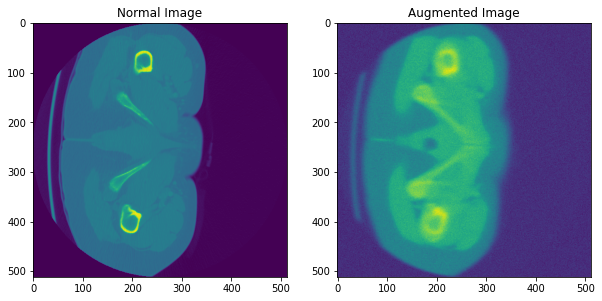

In [12]:
#THIS CELL IS FOR VISUALISATION PURPOSES ONLY
transform1 = torchvision.transforms.Compose(([tio.transforms.RandomBlur(std =5),
                                             tio.transforms.RandomGamma(log_gamma=1), 
                                             tio.transforms.RandomNoise(std = 5)]))
fig1, ax1 = plt.subplots(ncols = 2, figsize = (10,20))    
ax1[0].imshow(img_tensor[0])
ax1[0].set_title('Normal Image')   
ax1[1].imshow(transform1(img_tensor.unsqueeze(0))[0,0])   
ax1[1].set_title('Augmented Image')                   

plt.show()

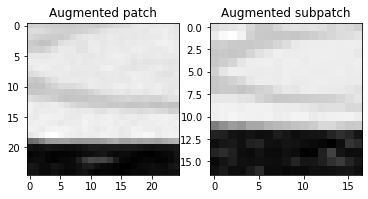

In [13]:
#we reduce the augmentation 
transform = torchvision.transforms.Compose(([tio.transforms.RandomBlur(std =0.1),
                                             tio.transforms.RandomGamma(0.1), 
                                             tio.transforms.RandomNoise(std = 0.1)]))
train_size= 35
test_size= 6

transformed_dataset = SpleenSegmentationDataset(meta, directory, transform = transform)

# TRAIN TEST SPLIT
transformed_train_set, transformed_test_set = torch.utils.data.random_split(transformed_dataset,[train_size, test_size])

#TRAIN AND TEST LOADERs
transformed_train_loader = torch.utils.data.DataLoader(transformed_train_set, batch_size=10, shuffle = True)
transformed_test_loader = torch.utils.data.DataLoader(transformed_test_set, batch_size=4, shuffle = True)

#VIEW ONE BATCH TO MAKE SURE IT WORKS 
im_batch, lab_batch, small_im_batch, small_seg_batch, segmentation = next(iter(transformed_train_loader))
fig, ax = plt.subplots(ncols = 2)
ax[0].imshow(im_batch[0,0,:,:,0], cmap = plt.cm.gray)
ax[0].set_title('Augmented patch')   
ax[1].imshow(small_im_batch[0,0,:,:,0], cmap = plt.cm.gray)
ax[1].set_title('Augmented subpatch')   
plt.show()

###**Training with Augmented Data**

In [14]:
pos_weight = torch.tensor((1.1))
pos_weight = pos_weight.to(device)
loss_fun = torch.nn.BCELoss(weight = pos_weight)

In [ ]:
epochs = 20
aug_train_loss = []
aug_val_loss=[]
aug_dice_scores = []
aug_path1 ='/content/drive/MyDrive/AML/FinalProjectSavedModels/train/augmented_train_model.pt'
aug_path2 = '/content/drive/MyDrive/AML/FinalProjectSavedModels/eval/augmented_test_model.pt'
SAVE_EVERY = 2

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#CREATE INSTANCE OF NETWORK & PASS TO NETWORK
deepmedic = DeepMedic()
deepmedic = deepmedic.to(device)
#deepmedic.load_state_dict(torch.load(path1))

optim = torch.optim.RMSprop(deepmedic.parameters(), lr=1e-4, momentum = 0.5, weight_decay =1e-4)
#optim = torch.optim.Adam(deepmedic.parameters(), lr=1e-4, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=6, gamma=0.1)


for epoch in range(epochs): 
    # enumerate can be used to output iteration index i, as well as the data 
    deepmedic.train()
    for i, (patch, seg, sub_patch, sub_patch_seg, net_seg) in enumerate(transformed_train_loader, 0):
        #print(patch.shape, seg.shape, sub_patch.shape, sub_patch_seg.shape)
        patch,sub_patch, net_seg = patch.to(device), sub_patch.to(device), net_seg.type(torch.FloatTensor).to(device)
        optim.zero_grad()
        output=deepmedic(patch, sub_patch)
        #print(output.shape)
        loss=loss_fun(torch.sigmoid(output),net_seg) #NOTE WE USE SIGMOID INSTEAD OF SOFTMAX SINCE ITS A BINARY SEGMENTATION PROBLEM
        loss.backward()
        optim.step()
        
        # print statistics of loss tensor
        ce_loss = loss.item()
        aug_train_loss.append(ce_loss)
        if i % 5 == 0:
            print('[%d, %5d] train loss: %.3f' %
                  (epoch + 1, i + 1, ce_loss))
    if epoch% SAVE_EVERY ==0:
        torch.save(deepmedic.state_dict(), aug-path1)
    scheduler.step()

    deepmedic.eval()
    for i, (patch, seg, sub_patch, sub_patch_seg, net_seg) in enumerate(transformed_test_loader, 0):
        patch,sub_patch, net_seg = patch.to(device), sub_patch.to(device), net_seg.type(torch.FloatTensor).to(device)
        pred=deepmedic(patch, sub_patch)
        loss=loss_fun(torch.sigmoid(pred),net_seg)
        ce_loss = loss.item()
        aug_val_loss.append(ce_loss)
        dicescore =dice_coeff(torch.sigmoid(pred), net_seg)
        dicescore = dicescore.item()       
        aug_dice_scores.append(dicescore)
        if i % 5 ==0:            
          print('[%d, %5d] val loss: %.3f' %
          (epoch + 1, i + 1, ce_loss))
    if epoch% SAVE_EVERY ==0:
        torch.save(deepmedic.state_dict(), aug_path2)

a_my_file = '/content/drive/MyDrive/AML/FinalProjectSavedModels/train/aug_losses2'
with open(a_my_file, 'wb') as f:
    pickle.dump(aug_train_loss, f)

a_my_file2 = '/content/drive/MyDrive/AML/FinalProjectSavedModels/eval/aug_losses2'
with open(a_my_file2, 'wb') as f:
    pickle.dump(aug_val_loss, f)

a_my_file3 = '/content/drive/MyDrive/AML/FinalProjectSavedModels/eval/aug_dice2'
with open(a_my_file3, 'wb') as f:
    pickle.dump(aug_dice_scores, f) 

In [ ]:
a_my_file = '/content/drive/MyDrive/AML/FinalProjectSavedModels/train/aug_losses'
a_my_file2 = '/content/drive/MyDrive/AML/FinalProjectSavedModels/eval/aug_losses'
a_my_file3 = '/content/drive/MyDrive/AML/FinalProjectSavedModels/eval/aug_dice'

with open(a_my_file, 'rb') as f:
    aug_train_loss= pickle.load( f)
with open(a_my_file2, 'rb') as f:
    aug_val_loss = pickle.load( f)
with open(a_my_file3, 'rb') as f:
    aug_dice_scores = pickle.load( f)


In [ ]:
fig, ax = plt.subplots(ncols = 3, figsize = (30,7))
epochs = 10
ax[0].plot(range(len(aug_train_loss)), aug_train_loss)
ax[0].set_title('Training Loss (CE)')
ax[0].set_xticks(np.arange(0, len(aug_train_loss), len(aug_train_loss)/epochs))
ax[0].set_xticklabels(range(1,epochs+1))
ax[0].set_xlabel('epochs')
ax[1].plot(range(len(aug_val_loss)), aug_val_loss)
ax[1].set_title('Testing Loss (CE)')
ax[1].set_xticks(np.arange(0, len(aug_val_loss), len(aug_val_loss)/epochs))
ax[1].set_xticklabels(range(1,epochs+1))
ax[1].set_xlabel('epochs')
ax[2].plot(range(len(aug_dice_scores)), aug_dice_scores)
ax[2].set_title('DICE SCORE')
ax[2].set_xticks(np.arange(0, len(aug_dice_scores), len(aug_dice_scores)/epochs))
ax[2].set_xticklabels(range(1,epochs+1))
ax[2].set_xlabel('epochs')

In [ ]:
print('Final Dice score:', np.round(aug_dice_scores[-1],4))

##**Plotting Segmentations for one batch**

In [ ]:
tensor = torch.round(torch.squeeze(torch.sigmoid(pred)))
tensor = tensor.cpu().detach().numpy()
net_seg = torch.squeeze(net_seg).cpu()
fig1, ax1 = plt.subplots(nrows= pred.shape[0], ncols = 2, figsize = (4,10))
print(pred.shape)
for i in range(pred.shape[0]):
  ax1[i, 0].imshow(tensor[i])
  ax1[i, 0].set_title('Predicted Segmentation')
  ax1[i, 1].imshow(net_seg[i])
  ax1[i, 1].set_title('True Segmentation')

plt.tight_layout()

##**Consistency Training**

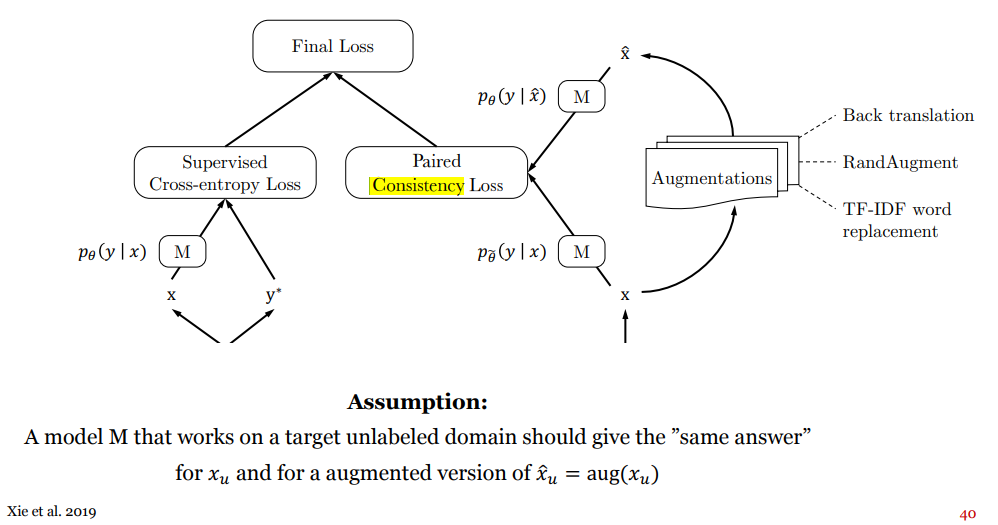

NOTE: we base our model on the above but use different transformations (ie those sepcified previously)

###**Dataset**

Coordinates of patch centre: [209. 343.  35.]


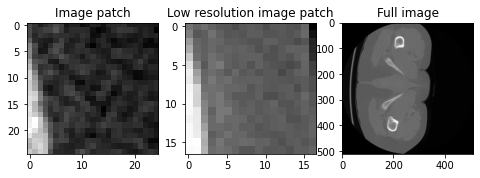

AA (17, 17, 17)
(25, 25, 25)


In [18]:
#CREATE A NEW PATCH SAMPLER 
#this is the same as before but does not return labels (Ie its for the unlabelled data)
def Csample_weighted_3d_patch(image, patch_size=25, sub_patch_size =17, seed=None, scale_factor = 2):
    np.random.seed(seed)
    scaledimage = block_reduce(image, block_size=(scale_factor,scale_factor,scale_factor), func = np.mean)
    shape = scaledimage.shape
    max_coords = np.array(shape) - sub_patch_size
    startcoords = np.zeros(len(shape), dtype=np.int32)

    for dim in range(len(shape)):
      if max_coords[dim] <= 0: 
        #pad the image
        padding = int(np.ceil(-1*max_coords[dim]/2))
        padlist = [(0,0),(0,0),(0,0)]
        padlist[dim] =(padding,padding)
        scaledimage = np.pad(scaledimage, padlist, mode='edge')
        max_coords[dim] = 0
      else:
        #Randomly pick a starting point for the patch, for each dimension
        startcoords[dim]  = np.random.randint(0, max_coords[dim])
      endcoords = startcoords + sub_patch_size

    sub_patch = scaledimage[startcoords[0] : endcoords[0],
                            startcoords[1] : endcoords[1],
                            startcoords[2] : endcoords[2]]

    #find and upscale the coordinates of the centre of the patch
    centercoords = (startcoords+endcoords)/2*scale_factor
    starting_patch_coords = (centercoords - np.ceil(patch_size/2)).astype(int)
    end_patch_coords = (centercoords + np.floor(patch_size/2)).astype(int)

    image_patch = image[starting_patch_coords[0]:end_patch_coords[0],
                        starting_patch_coords[1]:end_patch_coords[1],
                        starting_patch_coords[2]:end_patch_coords[2]]

    return image_patch, sub_patch, centercoords


#---------------------------------------------------------------------------------------------------------------------------------------------#
weight_map = seg
image_patch, sub_patch,  centercoords= Csample_weighted_3d_patch(img)
print(f'Coordinates of patch centre: {centercoords}')

#PLOTTING
fig, ax = plt.subplots(ncols=3, sharex=False, sharey=False,
                       figsize=(8, 4))
ax[0].imshow(image_patch[:,:,0], plt.cm.gray)
ax[0].set_title('Image patch')
ax[1].imshow(sub_patch[:,:,0], plt.cm.gray)
ax[1].set_title('Low resolution image patch')
ax[2].imshow(img[:,:,0],plt.cm.gray)
ax[2].set_title('Full image')
plt.show()
print('AA',label_sub_patch.shape)
print(image_patch.shape)
#print(segmentation_patch.shape)

In [19]:
#CREATING A NEW DATSET
#same as before except no lables
class CSpleenSegmentationDataset(torch.utils.data.Dataset): 
    
    def __init__(self, Cmeta, directory, transform=None): 

        self.directory = directory  #same directory
        self.cmeta = Cmeta #new meta path
        self.transform= transform
        
    def __len__(self):
        return len(Cmeta)
    
    def __getitem__(self, idx, patch_size=25,sub_patch_size= 17, acceptance_threshold=0.1, seed=None):
  
        meta_sample=self.cmeta[idx] # this will return the idx-th element from the dataframe
        image_name = os.path.join(directory, meta_sample)   
        image=nib.load(image_name).get_fdata().astype(float)
        
        image_patch, sub_patch, centercoords= Csample_weighted_3d_patch(image,patch_size,sub_patch_size)
       
        #converting to tensors 
        img_tensor = torch.from_numpy(image_patch).to(torch.float)
        sub_patch_tensor = torch.from_numpy(sub_patch).to(torch.float)
        
        # reshape to expected dimensions using permute and unsqueeze DO WE NEED TO PERMUTE?? 
        img_tensor=img_tensor.permute(2,0,1).unsqueeze(0)
        sub_patch_tensor = sub_patch_tensor.permute(2,0,1).unsqueeze(0)

        transformed_img_tensor = self.transform(img_tensor)
        transformed_sub_patch_tensor = self.transform(sub_patch_tensor)

        #return both augmented and original images since the loss functions compare the two 
        sample = img_tensor,sub_patch_tensor, transformed_img_tensor,transformed_sub_patch_tensor 
        return sample

In [20]:
transform2 = torchvision.transforms.Compose(([tio.transforms.RandomBlur(std =0.5),
                                             tio.transforms.RandomGamma(1), 
                                             tio.transforms.RandomNoise(std = 3)]))

20
torch.Size([1, 25, 25, 25]) torch.Size([1, 17, 17, 17])


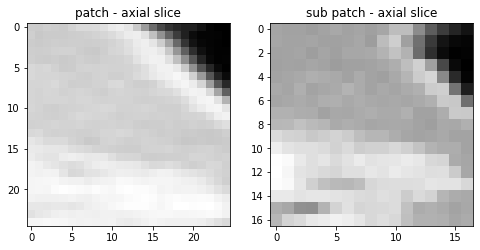

In [22]:
Ctrain_size = 17
Ctest_size = 3
#CHECKING THAT IT WORKS
#defining Cmeta
Cmeta_path=os.path.join(directory,'dataset.json')
with open(Cmeta_path, 'r') as f:
  data = json.load(f)
Cmeta = data['test']

cds = CSpleenSegmentationDataset(Cmeta, directory, transform=transform2)
print(cds.__len__())


# TRAIN TEST SPLIT
C_train_set, C_test_set = torch.utils.data.random_split(cds,[Ctrain_size, Ctest_size])

#TRAIN AND TEST LOADERS
C_train_loader = torch.utils.data.DataLoader(C_train_set, batch_size=10, shuffle = True)
C_test_loader = torch.utils.data.DataLoader(C_test_set, batch_size=6, shuffle = True)

img_tensor,sub_patch_tensor, transformed_img_tensor,transformed_sub_patch_tensor  = cds.__getitem__(0)
print(img_tensor.shape, sub_patch_tensor.shape)

#PLOTTING
fig, ax = plt.subplots(ncols=2, sharex=False, sharey = False,
                       figsize=(8, 4))
ax[0].imshow(img_tensor[0,:,:,0], cmap=plt.cm.gray)
ax[0].set_title('patch - axial slice')
ax[1].imshow(transformed_sub_patch_tensor[0,:,:,0], cmap = plt.cm.gray)

ax[1].set_title('sub patch - axial slice')
plt.show()

###**Training**

consistency loss trains well on its own with lr 0.01 momentum 0.6 and weight decay 1e-4 and normal supervised loss best with lr 1e-4


In [23]:
from itertools import cycle
#LOSSES
mse = torch.nn.MSELoss()
loss_fun = torch.nn.BCELoss(weight=None)

#SEED
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#CREATE INSTANCE OF NETWORK & PASS TO NETWORK
deepmedic = DeepMedic()
deepmedic = deepmedic.to(device)
#deepmedic.load_state_dict(torch.load(aug_path1))

optim = torch.optim.RMSprop(deepmedic.parameters(), lr=1e-4, momentum = 0.6, weight_decay =0)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=6, gamma=0.1)

alpha = 0.9
beta = 0.1
train_losses = []
train_c_losses=[]
train_final_losses = []
test_losses = []
test_c_losses = []
test_final_losses =[]
dice_scores = []
epochs = 35
SAVE_EVERY = 2

c_path_1 = '/content/drive/MyDrive/AML/FinalProjectSavedModels/train/c_train_model.pt'
c_path_2 = '/content/drive/MyDrive/AML/FinalProjectSavedModels/train/c_test_model.pt'

In [ ]:

#-----------------------------------------------------------------------------------------------------------------------------------------------#

for epoch in range(epochs):
    deepmedic.train()
    for batch_idx, (data1,data2) in enumerate(zip(cycle(C_train_loader), transformed_train_loader)): #we cycle since size of C_train loader < train_loader
      c_img,c_sub_patch, c_transformed_img,c_transformed_sub_patch = data1
      patch, seg, sub_patch, sub_patch_seg, net_seg = data2
      c_img,c_sub_patch, c_transformed_img,c_transformed_sub_patch = c_img.to(device),c_sub_patch.to(device), c_transformed_img.to(device),c_transformed_sub_patch.to(device)
      patch,sub_patch, net_seg = patch.to(device), sub_patch.to(device), net_seg.type(torch.FloatTensor).to(device)

      optim.zero_grad()

      output=deepmedic(patch, sub_patch)
      loss=loss_fun(torch.sigmoid(output),net_seg)
      train_losses.append(loss.item())

      c_output = deepmedic(c_img, c_sub_patch)
      ctr_output = deepmedic(c_transformed_img, c_transformed_sub_patch)
      c_loss = mse(ctr_output, c_output) 
      train_c_losses.append(c_loss.item())

      final_loss = alpha*loss + beta*c_loss
      train_final_losses.append(final_loss.item())
      final_loss.backward()
      optim.step()
    scheduler.step()
    if epoch % SAVE_EVERY == 0:
      torch.save(deepmedic.state_dict(), c_path_1)
    print('TRAINING:','loss:', np.round(loss.item(),4), 'c_loss:',np.round(c_loss.item(),4), 'final_loss:',np.round(final_loss.item(),4))

    deepmedic.eval()
    for batch_idx, (data1, data2) in enumerate(zip(cycle(C_test_loader), test_loader)):
      c_img,c_sub_patch, c_transformed_img,c_transformed_sub_patch = data1
      patch, seg, sub_patch, sub_patch_seg, net_seg = data2
      c_img,c_sub_patch, c_transformed_img,c_transformed_sub_patch = c_img.to(device),c_sub_patch.to(device), c_transformed_img.to(device),c_transformed_sub_patch.to(device)
      patch, seg, sub_patch, sub_patch_seg, net_seg = patch.to(device), seg.to(device), sub_patch.to(device), sub_patch_seg.to(device), net_seg.type(torch.FloatTensor).to(device)
      
      output=deepmedic(patch, sub_patch)
      loss=loss_fun(torch.sigmoid(output),net_seg)
      test_losses.append(loss.item())
      dice_score = dice_coeff(torch.sigmoid(output), net_seg)
      dice_scores.append(dice_score.item())
      c_output = deepmedic(c_img, c_sub_patch)
      ctr_output = deepmedic(c_transformed_img, c_transformed_sub_patch)
      c_loss = mse(ctr_output,c_output)
      test_c_losses.append(c_loss.item())

      final_loss = alpha*loss + beta*c_loss
      
      test_final_losses.append(final_loss.item())
    if epoch % SAVE_EVERY == 0:
      torch.save(deepmedic.state_dict(), c_path_2)

    print('TESTING:','loss:', np.round(loss.item(),4), 'c_loss:',np.round(c_loss.item(),4), 'final_loss:',np.round(final_loss.item(),4))


In [ ]:

fig, ax = plt.subplots(ncols = 3, figsize = (30,7))
ax[0].plot(range(len(train_losses)), train_losses, label = 'Supervised Loss')
ax[0].plot(range(len(train_c_losses)), train_c_losses, label = 'Unsupervised Consistency Loss')
ax[0].plot(range(len(train_final_losses)),train_final_losses, label = 'Total Loss')
ax[0].set_title('Training Losses')
ax[0].legend()
ax[0].set_xticks(np.arange(0, len(train_losses), len(train_losses)/epochs))
ax[0].set_xticklabels(range(1,epochs+1))
ax[0].set_xlabel('epochs')

ax[1].plot(range(len(test_losses)), test_losses)
ax[1].set_title('Testing Loss (CE)')
ax[1].set_xticks(np.arange(0, len(test_losses), len(test_losses)/epochs))
ax[1].set_xticklabels(range(1,epochs+1))
ax[1].set_xlabel('epochs')
ax[2].plot(range(len(dice_scores)), dice_scores)
ax[2].set_title('Testing Loss (DICE)')
ax[2].set_xticks(np.arange(0, len(dice_scores), len(dice_scores)/epochs))
ax[2].set_xticklabels(range(1,epochs+1))
ax[2].set_xlabel('epochs')


##**Uncertainty calculations**

"For this we turn the heteroscedastic NN in §2.2 into a Bayesian NN by placing a distribution over its weights"
- dropout before every weight layer 
- network should return variance or log var 
  - we train the network to predict the log variance. This is because it is more numerically stable than regressing the variance, as the loss avoids a potential division by zero. 
  
Loss function for heteroscedastic neural net (as taken from the Kendall and Gal paper):

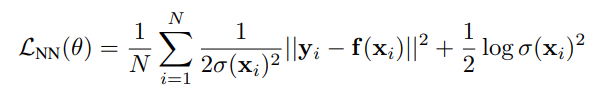
.


In [ ]:
#OUR NETWROK SHOULD RETURN THE LOG VARIANCE? 
class ResBlock(nn.Module):
    def __init__(self, inplanes, planes, dropout=0.2):
        super(ResBlock, self).__init__()
        self.inplanes = inplanes
        self.conv1 = nn.Conv3d(inplanes, planes, 3, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(planes, planes, 3, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        y = self.relu(self.bn1(self.dropout(self.conv1(x))))
        y = self.bn2(self.dropout(self.conv2(y)))
        x = x[:, :, 2:-2, 2:-2, 2:-2]
        y[:, :self.inplanes] += x
        y = self.relu(y)
        return y

def conv3x3(inplanes, planes, ksize=3,dropout =0.2):
    return nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv3d(inplanes, planes, ksize, bias=False),
            nn.BatchNorm3d(planes),
            nn.ReLU(inplace=True))

def repeat(x, n=3):
    # nc333
    b, c, h, w, t = x.shape
    x = x.unsqueeze(5).unsqueeze(4).unsqueeze(3)
    x = x.repeat(1, 1, 1, n, 1, n, 1, n)
    return x.view(b, c, n*h, n*w, n*t)


class DeepMedic(nn.Module):
    def __init__(self, c=1, n1=30, n2=40, n3=50, m=150, up=True, dropout =0.2):
        super(DeepMedic, self).__init__()
        #n1, n2, n3 = 30, 40, 50

        n = 2*n3
        self.branch1 = nn.Sequential(
                conv3x3(c, n1),
                conv3x3(n1, n1),
                ResBlock(n1, n2),
                ResBlock(n2, n2),
                ResBlock(n2, n3))

        self.branch2 = nn.Sequential(
                conv3x3(c, n1,),
                conv3x3(n1, n1),
                conv3x3(n1, n2),
                conv3x3(n2, n2),
                conv3x3(n2, n2),
                conv3x3(n2, n2),
                conv3x3(n2, n3),
                conv3x3(n3, n3))

        self.up3 = nn.Upsample(scale_factor=3,
                mode='trilinear', align_corners=False) if up else repeat

        self.fc = nn.Sequential(
                conv3x3(100, 150, 1),
                conv3x3(150, 150, 1),
                nn.Dropout(dropout),
                nn.Conv3d(150, 1, 1))
      

    def forward(self, inputs, small_inputs):
        x1, x2 = inputs, small_inputs
        x1 = self.branch1(x1)
        x2 = self.branch2(x2)
        x2 = self.up3(x2)
        x2 = self.up3(x2) #we add antóther upsampling since weve reduced the image size of the subpatches from 19 to 17
        x = torch.cat([x1, x2], 1)
        x = self.fc(x)
        
        log_variance = 
        return x, log_variance 

In [ ]:
unc_loss_func = torch.sum(0.5*torch.exp(-1*log_variance)*torch.square(torch.abs(net_seg-output))+ 0.5*log_variance 

##**Ensemble**

Due to the varying output sizes of everyone's models we chose to all compare an 18x18x18 patch centered at (200,110,15) from 'spleen_56.nii.gz'. This region partly contains a spleen. 
Since the output of all of the DeepMedic networks is a 9x9x9 patch, 8 such patches were concatenated to produce the larger 18x18x18 volume. 

###**Loading the Image**

(512, 512, 80) (512, 512, 80)
torch.Size([80, 512, 512])


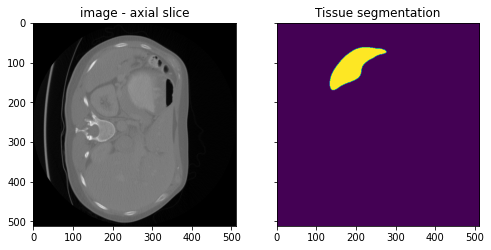

In [25]:
image_file=nib.load(os.path.join(directory,'imagesTr/spleen_62.nii.gz')) # see here use of os.path.join to create the final path
segmentation_file=nib.load(os.path.join(directory,'labelsTr/spleen_62.nii.gz'))

img=image_file.get_fdata().astype(float)
seg=segmentation_file.get_fdata().astype(np.int32)
print(img.shape,seg.shape)

#CONVERT TO TENSORS AND RESHAPE
img_tensor = torch.from_numpy(img).to(torch.float).permute(2,0,1)
seg_tensor=torch.from_numpy(seg).to(torch.int).permute(2,0,1)
print(img_tensor.shape)

#PLOTTING
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(8, 4))
ax[0].imshow(img_tensor[64], cmap=plt.cm.gray)
ax[0].set_title('image - axial slice')
ax[1].imshow(seg_tensor[64])
ax[1].set_title('Tissue segmentation')
plt.show()

###**Updated 3D sampler (with fixed start coords)**

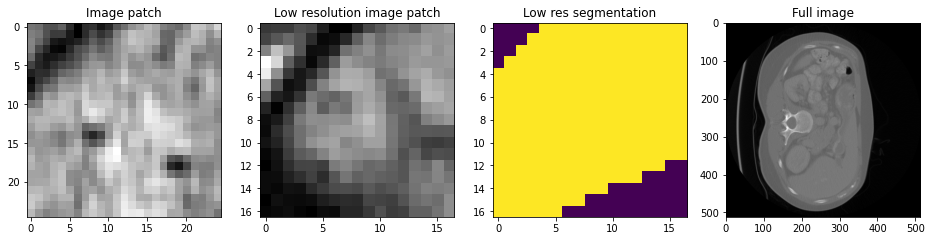

AA (17, 17, 17)
(25, 25, 25)


In [28]:
def sample_weighted_3d_patch(image, weight_map, center_coords, patch_size=25, sub_patch_size =17, net_size = 9, scale_factor = 2):
    scaledimage = block_reduce(image, block_size=(scale_factor,scale_factor,scale_factor), func = np.mean) 
    scaledlabels = block_reduce(weight_map, block_size=(scale_factor,scale_factor,scale_factor), func=np.mean).astype(int)


    starting_patch_coords = (center_coords-np.ceil(patch_size/2)).astype(int)
    end_patch_coords = starting_patch_coords + patch_size
    image_patch = image[starting_patch_coords[0]:end_patch_coords[0],
                        starting_patch_coords[1]:end_patch_coords[1],
                        starting_patch_coords[2]:end_patch_coords[2]]

    label_patch = weight_map[starting_patch_coords[0]:end_patch_coords[0],
                             starting_patch_coords[1]:end_patch_coords[1],
                             starting_patch_coords[2]:end_patch_coords[2]]

    startcoords = (np.divide(center_coords,scale_factor) - np.ceil(sub_patch_size/2)).astype(int)
    endcoords = startcoords + sub_patch_size
    sub_patch = scaledimage[startcoords[0] : endcoords[0],
                            startcoords[1] : endcoords[1],
                            startcoords[2] : endcoords[2]]
    label_sub_patch = scaledlabels[startcoords[0] : endcoords[0],
                                   startcoords[1] : endcoords[1],
                                   startcoords[2] : endcoords[2]]

    starting_patch_coords2 = (center_coords - np.ceil(net_size/2)).astype(int)
    end_patch_coords2 = (center_coords + np.floor(net_size/2)).astype(int)
    
    network_label_patch = weight_map[starting_patch_coords2[0]:end_patch_coords2[0],
                                     starting_patch_coords2[1]:end_patch_coords2[1],
                                     starting_patch_coords2[2]:end_patch_coords2[2]]
    return image_patch, sub_patch, label_patch, label_sub_patch, network_label_patch

weight_map = seg
image_patch, sub_patch, label_patch, label_sub_patch, net_label_patch = sample_weighted_3d_patch(img, weight_map, (115,195,61))
img_tensor1 = torch.from_numpy(image_patch).to(torch.float)
img_tensor1=img_tensor1.unsqueeze(0).unsqueeze(0)


fig, ax = plt.subplots(ncols=4, sharex=False, sharey=False,
                       figsize=(16, 5))
ax[0].imshow(image_patch[:,:,0], plt.cm.gray)
ax[0].set_title('Image patch')
ax[1].imshow(sub_patch[:,:,5], plt.cm.gray)
ax[1].set_title('Low resolution image patch')
ax[2].imshow(label_sub_patch[:,:,8])
ax[2].set_title('Low res segmentation')
ax[3].imshow(img[:,:,56],plt.cm.gray)
ax[3].set_title('Full image')
plt.show()
print('AA',label_sub_patch.shape)
print(image_patch.shape)

###**Evaluating**

We evaluate 4 9x9x9x patches which when combined form a larger 18x18x18 patch. The center coordinates of patches in the front and back layers are given in coordinate_list1 and coordinate_list2.

> 


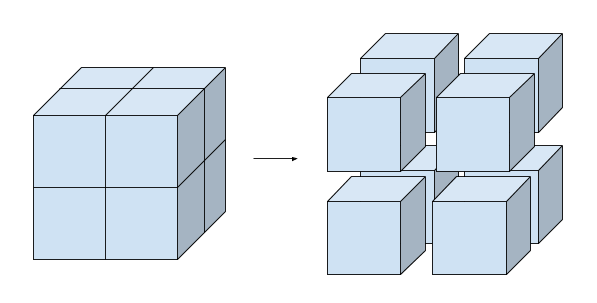

In [29]:
#we create two coordinate list
coordinate_list1 = [(115,195,51), 
                   (115,205,51),
                   (105,195,51), 
                   (105,205, 51)]
coordinate_list2 = [(115,195,61),
                   (115,205,61),
                   (105,195,61),
                   (105,205,61)]

prediction = torch.zeros((9,36,9))
prediction.to(device)
truelabel = torch.zeros((9,36,9))

aug_path1 ='/content/drive/MyDrive/AML/FinalProjectSavedModels/train/augmented_train_model.pt'
deepmedic = DeepMedic()
deepmedic.load_state_dict(torch.load(aug_path1))
deepmedic.to(device)
i= 0
for coordinates in coordinate_list1:
  deepmedic.eval()
  image_patch, sub_patch, label_patch, label_sub_patch, net_label_patch = sample_weighted_3d_patch(img, weight_map, coordinates)
  img_tensor = torch.from_numpy(image_patch).to(torch.float)
  sub_patch_tensor = torch.from_numpy(sub_patch).to(torch.float)
  segmentation_tensor = torch.from_numpy(net_label_patch).to(torch.int)
  img_tensor=img_tensor.permute(2,0,1).unsqueeze(0).unsqueeze(0)
  sub_patch_tensor = sub_patch_tensor.permute(2,0,1).unsqueeze(0).unsqueeze(0)
  segmentation_tensor = segmentation_tensor.permute(2,0,1).unsqueeze(0).unsqueeze(0).type(torch.FloatTensor)
  img_tensor = img_tensor.to(device)
  sub_patch_tensor = sub_patch_tensor.to(device)
  pred = deepmedic(img_tensor, sub_patch_tensor)
  pred = torch.squeeze(torch.sigmoid(pred))
  prediction[:, i*9:(i+1)*9]=pred
  truelabel[:,i*9:(i+1)*9]=segmentation_tensor
  i+=1

reshaped_prediction = prediction.reshape((18,18,9))
reshaped_truelabel = truelabel.reshape((18,18,9))

prediction2 = torch.zeros((9,36,9))
truelabel2 = torch.zeros((9,36,9))
j = 0
for coordinates in coordinate_list2:
  deepmedic.eval()
  image_patch, sub_patch, label_patch, label_sub_patch, net_label_patch = sample_weighted_3d_patch(img, weight_map, coordinates)
  img_tensor = torch.from_numpy(image_patch).to(torch.float)
  sub_patch_tensor = torch.from_numpy(sub_patch).to(torch.float)
  segmentation_tensor = torch.from_numpy(net_label_patch).to(torch.int)
  img_tensor=img_tensor.permute(2,0,1).unsqueeze(0).unsqueeze(0)
  sub_patch_tensor = sub_patch_tensor.permute(2,0,1).unsqueeze(0).unsqueeze(0)
  segmentation_tensor = segmentation_tensor.permute(2,0,1).unsqueeze(0).unsqueeze(0).type(torch.FloatTensor)
  img_tensor = img_tensor.to(device)
  sub_patch_tensor = sub_patch_tensor.to(device)
  pred = deepmedic(img_tensor, sub_patch_tensor)
  pred = torch.squeeze(torch.sigmoid(pred))
  prediction2[:,j*9:(j+1)*9]=pred
  truelabel2[:,j*9:(j+1)*9]=segmentation_tensor
  j+=1

reshaped_prediction2 = prediction2.reshape((18,18,9))
reshaped_truelabel2 = truelabel2.reshape((18,18,9))

final_prediction = torch.cat((reshaped_prediction, reshaped_prediction2), dim = 2)
final_truelabel = torch.cat((reshaped_truelabel, reshaped_truelabel2),axis = 2)
print(final_prediction.shape)
print(final_truelabel.shape)


tensorfile = '/content/drive/MyDrive/AML/FinalProjectSavedModels/deepmedic_saga.pt'
torch.save(final_prediction, tensorfile)
#torch.load(tensorfile)

torch.Size([18, 18, 18])
torch.Size([18, 18, 18])


###**Plotting the segmentation**

DICE SCORE: 0.9477


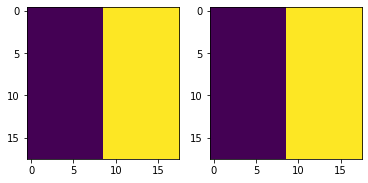

In [30]:
fig, ax = plt.subplots(ncols =2)
ax[0].imshow(torch.round(final_prediction[8]).detach())
ax[1].imshow(final_truelabel[8])
dice_score = np.round(dice_coeff(final_prediction, final_truelabel).item(),4)
print('DICE SCORE:', dice_score)

##**Loading and ensembling the results from the different models**

**Start with equally weighted models**

DICE SCORE: 0.815375804901123


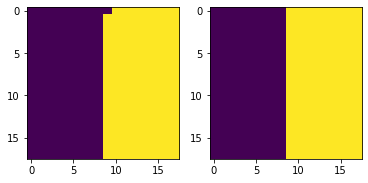

In [39]:
model1 = torch.load('/content/drive/MyDrive/AML/FinalProjectSavedModels/team_jiawei.pt').to(device)
model2 = torch.load('/content/drive/MyDrive/AML/FinalProjectSavedModels/weiwei.pt').to(device)
model3 = torch.load('/content/drive/MyDrive/AML/FinalProjectSavedModels/Teams5.pt').to(device)
model4 = torch.load('/content/drive/MyDrive/AML/FinalProjectSavedModels/pred.zip').to(device)
model5 = torch.load('/content/drive/MyDrive/AML/FinalProjectSavedModels/deepmedic_saga.pt').to(device)

ensembled_prediction = ((model1+model2+model3+model4+model5)/ 5).detach().cpu()
ensembled_dice_score = dice_coeff(ensembled_prediction, final_truelabel)

fig, ax = plt.subplots(ncols= 2)
ax[0].imshow(torch.round(ensembled_prediction[16]))
ax[1].imshow(final_truelabel[14])
print('DICE SCORE:', ensembled_dice_score.item())

**Changing the weights**

Each model's DICE when evaluated on their own: 


*   A: 0.9751
*   B: 0.1214
*   C: 0.6563
*   D: 0.0004
*   E: 0.9477





DICE SCORE: 0.9778335690498352


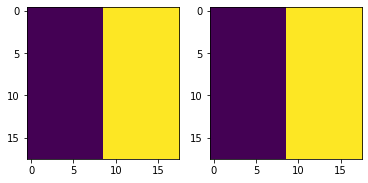

In [38]:
A = 4
B = 0
C = 0
D = 0
E = 1


weighted_ensembled_prediction = ((A*model1+B*model2+C*model3+D*model4+E*model5)/ 5).detach().cpu()
weighted_ensembled_dice_score = dice_coeff(weighted_ensembled_prediction, final_truelabel)

fig, ax = plt.subplots(ncols= 2)
ax[0].imshow(torch.round(weighted_ensembled_prediction[16]))
ax[1].imshow(final_truelabel[14])

print('DICE SCORE:', weighted_ensembled_dice_score.item())